# ML Model for Groundwater detection based on resistivity values
**Author: Camilo Mejía**

Import Dependencies

In [25]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
from flask import Flask, request, jsonify
from sklearn.pipeline import Pipeline

Load dataset

In [26]:
inputfile = 'data_for_training/Guapota_Res.csv'
raw_data = pd.read_csv(inputfile, delimiter= ',')  # Adjust delimiter if needed
print(raw_data.head(3))

   elec_pos  depth     rho      cond
0      0.75  0.375  225.18  0.004441
1      2.25  0.375  188.92  0.005293
2      3.75  0.375  200.83  0.004979


Define rho thereshold and add a new column to define groundwater presence

In [27]:
rho_threshold = 100
raw_data['groundwater_presence'] = (raw_data['rho'] < rho_threshold).astype(int)

Save the new csv including groundwater presence column

In [28]:
output_file_path = "data_for_training/Groundwater_presence.csv"
raw_data.to_csv(output_file_path, index=False)

Define our training data

In [29]:
fixed_input = "data_for_training/Groundwater_presence.csv"
data = pd.read_csv(fixed_input, delimiter = ',')
print(data.head(50))

    elec_pos  depth       rho      cond  groundwater_presence
0       0.75  0.375   225.180  0.004441                     0
1       2.25  0.375   188.920  0.005293                     0
2       3.75  0.375   200.830  0.004979                     0
3       5.25  0.375   199.620  0.005010                     0
4       6.75  0.375   303.020  0.003300                     0
5       8.25  0.375   883.190  0.001132                     0
6       9.75  0.375  3176.600  0.000315                     0
7      11.25  0.375  6674.000  0.000150                     0
8      12.75  0.375  1474.200  0.000678                     0
9      14.25  0.375    64.377  0.015500                     1
10     15.75  0.375    72.057  0.013900                     1
11     17.25  0.375    53.930  0.018500                     1
12     18.75  0.375   109.800  0.009107                     0
13     20.25  0.375   229.720  0.004353                     0
14     21.75  0.375   202.000  0.004950                     0
15     2

# Step 2: QA/QC processing to remove outlier values

Assuming you have 2D resistivity values (x, depth, rho) and an indicator for groundwater presence
Example: x_coord, y_coord, rho, groundwater_presence, groundwater_depth

Calculate the z-scores of the resistivity values

In [30]:
z_scores = (data['rho'] - data['rho'].mean()) / data['rho'].std()

Define a threshold for z-scores beyond which data points are considered outliers


In [31]:
z_score_threshold = 3  # Adjust this threshold as needed

Create a boolean mask to identify outlier data points

In [32]:
outliers_mask = abs(z_scores) > z_score_threshold

Remove outlier data points from the dataset

In [33]:
data_no_outliers = data[~outliers_mask]

# Step 3: Data splitting

In [34]:
X = data_no_outliers.drop(["groundwater_presence"], axis=1)  # Features (elec_pos, depth, rho, cond)
y_presence = data_no_outliers["groundwater_presence"]  # Target variable for presence
X_train, X_test, y_presence_train, y_presence_test = train_test_split(X, y_presence, test_size=0.2, random_state=42)

# Step 4: Model selection

In [35]:
model = RandomForestClassifier(random_state=42)

# Step 5: Model training

In [36]:
model.fit(X_train, y_presence_train)

RandomForestClassifier(random_state=42)

# Step 6: Model evaluation

In [37]:
y_presence_pred = model.predict(X_test)
accuracy_presence = accuracy_score(y_presence_test, y_presence_pred)
classification_rep_presence = classification_report(y_presence_test, y_presence_pred)
print("Accuracy for Groundwater Presence:", accuracy_presence)
print("Classification Report for Groundwater Presence:\n", classification_rep_presence)

Accuracy for Groundwater Presence: 1.0
Classification Report for Groundwater Presence:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        54
           1       1.00      1.00      1.00         8

    accuracy                           1.00        62
   macro avg       1.00      1.00      1.00        62
weighted avg       1.00      1.00      1.00        62



# Step 7: Hyperparameter tuning (optional)

In [38]:
param_grid = {
    'clf__n_estimators': [100, 200, 300],
    'clf__max_depth': [None, 10, 20],
    'clf__min_samples_split': [2, 5, 10],
    'clf__min_samples_leaf': [1, 2, 4]
}

pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Feature scaling
    ('clf', RandomForestClassifier(random_state=42))
])

grid_search = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_presence_train)

best_model_presence = grid_search.best_estimator_

# Step 8: Model interpretation

In [39]:
importances_presence = best_model_presence.named_steps['clf'].feature_importances_
feature_names_presence = X_train.columns
feature_importances_presence = dict(zip(feature_names_presence, importances_presence))
sorted_feature_importances_presence = sorted(feature_importances_presence.items(), key=lambda x: x[1], reverse=True)

print("Feature Importances for Groundwater Presence:")
for feature, importance in sorted_feature_importances_presence:
    print(f"{feature}: {importance}")

Feature Importances for Groundwater Presence:
cond: 0.4874854112203674
rho: 0.48595880700634425
depth: 0.024578194456372146
elec_pos: 0.0019775873169161438


# Step 9: Prediction and visualization

Import dependencies

In [40]:
import numpy as np
import matplotlib.pyplot as plt

Create a meshgrid for electrode position and depth

In [45]:
elec_pos_values = np.unique(X_test['elec_pos'])
depth_values = np.unique(X_test['depth'])
X, Y = np.meshgrid(elec_pos_values, depth_values)

Reshape the data for visualization: create a new array to hold the predicted values. Initialize it with zeros & terate through your y_presence_pred array and assign the values to the corresponding positions in the Z array using the meshgrid indices

In [53]:
Z = np.zeros(X.shape)  # Initialize an empty grid
index = 0
for i, elec_pos in enumerate(elec_pos_values):
    for j, depth in enumerate(depth_values):
        if index < len(y_presence_pred):  # Make sure to access valid indices
            Z[j, i] = y_presence_pred[index]
        index += 1
        if index >= len(y_presence_pred):
            break  # Exit the loop if we've reached the end of y_presence_pred

Create the contour plot

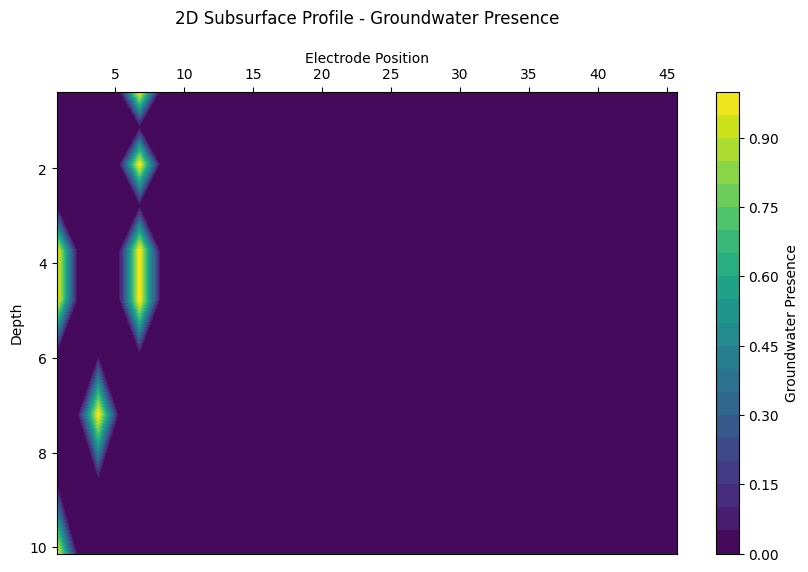

In [62]:
plt.figure(figsize=(10, 6))
contour = plt.contourf(X, Y, Z, levels=20, cmap='viridis')
 
plt.title('2D Subsurface Profile - Groundwater Presence', pad=20)

plt.colorbar(contour, label='Groundwater Presence')

plt.xlabel('Electrode Position')
plt.gca().xaxis.tick_top()
plt.gca().xaxis.set_label_position('top')

plt.ylabel('Depth')
plt.gca().xaxis.tick_top()
plt.gca().invert_yaxis()  

plt.savefig('2d_subsurface_profile_presence.png')
plt.show()

# Step 10: Model deployment (optional)

In [58]:
app = Flask(__name__)

@app.route('/predict', methods=['POST'])
def predict():
    data = request.json  # Assuming you send JSON data with x, y, and rho values
    prediction_presence = best_model_presence.predict([data])[0]
    response = {'groundwater_presence_prediction': 'Yes' if prediction_presence == 1 else 'No'}
    return jsonify(response)

if __name__ == '__main__':
    app.run()

 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on http://127.0.0.1:5000
Press CTRL+C to quit
